<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_02_neural_network_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Make classification data**
1. Binary classification
2. Multiclass classification
3. Multilabel classfication

In [6]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create data (circles)
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [7]:
# Check shape
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# Check our sample data
print("First 5 samples of X:\n", X[:5], "\n")
print("First 5 samples of y:\n", y[:5])

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 

First 5 samples of y:
 [1 1 1 1 0]


In [9]:
# DataFrame
import pandas as pd

circles = pd.DataFrame( {"X1" : X[:,0],
                         "X2" : X[:,1],
                         "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


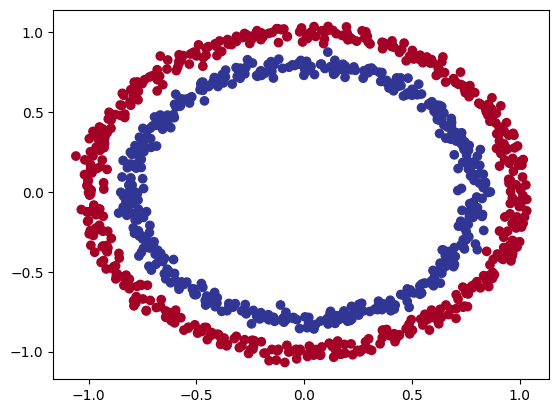

In [10]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,   # colored by label
            cmap=plt.cm.RdYlBu)

# 1.1 Check data shape

In [11]:
X.shape, y.shape

((1000, 2), (1000,))

In [12]:
# check
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

# 1.2 Trun data into tensor and create train, test splits

In [13]:
import torch
torch.__version__

'2.0.1+cu118'

In [14]:
# Turn data into torch.Tensor
print("轉換前: ", X.dtype)   # numpy 資料型態 dtype('float64')

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print("轉換後:\nX", X.dtype, "\ny", y.dtype)

轉換前:  float64
轉換後:
X torch.float32 
y torch.float32


In [15]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print("X info:\n", X_train.shape, X_test.shape, "\n")
print("y info:\n", y_train.shape, y_test.shape)

X info:
 torch.Size([800, 2]) torch.Size([200, 2]) 

y info:
 torch.Size([800]) torch.Size([200])


# **2. Build model**

1. Setup device
2. Construct model
    1. by subclassing `nn.module`
3. Define loss function and optimizer
    1. loss function : non linear function
    2. optimizer : `SGD` or `Adam`
4. Create training and testing loop
    1. training : forward -> calculate loss -> backward -> eval
    2. testing : forward -> eval

# 2.1 Setup device

In [16]:
import torch
from torch import nn

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 2.2 Construct and create model
1. Subclass "nn.Module" (almost all models in Pytorch subclass "nn.Moudle")
2. Create 2 "nn.Linear()" layers (since our data got 2 classes)
3. Define "forward()"
4. Actual create our model and send it to the target device

In [17]:
# 1. Subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # 2. Create 2 nn.Linear (兩層)
        self.layer_1 = nn.Linear(in_features=2, out_features=8) # 自己定義特徵數量
        self.layer_2 = nn.Linear(in_features=8, out_features=1) # 最後輸出 1 特徵

    # 3. Define forward() -> outline forward pass
    #    x -> layer_1 -> layer_2 -> output
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

# 4. Create model
#    and send to target devide
model_0 = CircleModelV0().to(device)

# Check model's content
print("model_0\n", model_0)

model_0
 CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)


# 2.2.1 Different way to construct and create our model

In [18]:
# 使用 nn.Sequential() 建立模型
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

print("model_1\n", model_1)

model_1
 Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)


測試模型能否預測 ()

In [19]:
# 額外 : Make prediction
with torch.inference_mode():
    untrained_preds = model_1(X_test.to(device))

print("預測數量: ", len(untrained_preds))
print("Shape of prediction: ", untrained_preds.shape)

print("\nX_test 數量: ", len(X_test))
print("Shape of test: ", X_test.shape)

print("\nFirst 10 prediction\n", torch.round(untrained_preds[:10]))
print("\nFirst 10 labels", y_test[:10])

預測數量:  200
Shape of prediction:  torch.Size([200, 1])

X_test 數量:  200
Shape of test:  torch.Size([200, 2])

First 10 prediction
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]])

First 10 labels tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# 2.3 Choose loss function and optimizer
1. For regression : usually MAE or MSE
2. For classification : usually binary cross entropy or categorical cross entropy
3. Optimizer : usually Adam or SGD
4. More info : https://www.learnpytorch.io/02_pytorch_classification/

In [20]:
# Setup loss function (取決於我們分析的問題)
# 這邊的問題是 binary
loss_fn = nn.BCEWithLogitsLoss()   # sigmoid function build-in

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [21]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    # eq -> how many y_true = y_pred
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

# **3. Train model**
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. backward pass (Loss backward)
5. Optimizer (gradient descent)

# 3.1 Layer explain (Lofits)

1. Logits : 接收前一層輸出, 將其轉換為`模型的預測得分` or `概率分佈`
2. Softmax (probabilities): 將logits的概率分佈, 映射到 0-1 之間的概率值, 目的使所有類別的概率總和為1
3. prediction labels : 取出機率最大者 (`round()` or `argmax()`), 將其與label對應, 方便人類檢視

In [22]:
# View the first 5 outputs of the forward pass on the test data

# 轉換為 evaluate 模式
model_1.eval()

# 只是檢視最後預測值 所以關閉梯度計算
with torch.inference_mode():
    y_logits = model_1(X_test.to(device))[:5]

# 比較 logits and y_test
y_logits, y_test[:5]

(tensor([[0.3006],
         [0.3041],
         [0.3961],
         [0.2731],
         [0.5621]]),
 tensor([1., 0., 1., 0., 1.]))

In [23]:
# 使用 sigmoid 激活 logits
# y_pred_probs < 0.5 將被歸類到 class 0 y=0
# y_pred_probs >= 0.5 將被歸類到 class 1 y=1

y_pred_probs = torch.sigmoid(y_logits)

# sigmoid 激活後 -> round
y_pred = torch.round(y_pred_probs)

print("激活後:\n", y_pred_probs, "\n")
print("After rounded:\n", y_pred)

激活後:
 tensor([[0.5746],
        [0.5754],
        [0.5977],
        [0.5679],
        [0.6369]]) 

After rounded:
 tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])


In [24]:
# prediction labels # 將 cell 21 - 22 一次做完
# 使用 sigmoid 將 logits 轉為機率
# 使用 round 將機率 轉換為 0 or 1 labels
y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_pred.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_pred.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [25]:
# 檢查 預測值 與 test 是否一樣

y_pred_labels.squeeze(), y_test[: 5]

(tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>),
 tensor([1., 0., 1., 0., 1.]))

# 3.2 train

In [26]:
# torch.manual_seed(42)   # torch.cuda.manual_seed(42) 也可以

# # set number of epochs
# epochs = 100

# # Put data to target device
# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

# # Build training and evaluate loop
# for epoch in range(epochs):
#     # Training !!!
#     model_1.train()

#     # 1. Forward pass
#     y_logits = model_1(X_train).squeeze()
#     # 1.1 turn logits into probilities and then trun into labels
#     y_pred = torch.round(torch.sigmoid(y_logits))

#     # 2. Calculate loss/accuracy
#     # Loss function : nn.BCEWithLogitsLoss 需使用 logits 為input
#     # Compare with y_train
#     loss = loss_fn(y_logits,
#              y_train)
#     acc = accuracy_fn(y_true = y_train,
#                y_pred = y_pred)

#     # 3. Optimizer zero grad
#     optimizer.zero_grad()

#     # 4. Loss backward
#     loss.backward()

#     # 5. Optimizer step
#     optimizer.step()

#     # Test !!!
#     model_1.eval()
#     with torch.no_grad():
#         # 1. Forward pass
#         test_logits = model_1(X_test).squeeze()
#         test_pred = torch.round(torch.sigmoid(test_logits))

#         # 2. Calculate loss/acc
#         # Loss function : nn.BCEWithLogitsLoss 需使用 logits 為input
#         # Compare with y_test
#         test_loss = loss_fn(test_logits,
#                     y_test)
#         test_acc = accuracy_fn(y_true = y_test,
#                      y_pred = test_pred)

#         # 3. Print out the process
#         if epoch % 10 == 0:
#             print(f"Epoch: {epoch}")
#             print(f"Loss: {loss:.4f}, Acc:{acc:.2f}%")
#             print(f"Test loss: {test_loss:.4f}, Test acc:{test_acc:.2f}%")
#             print("=" * 50)

# **3.2 Train**
**Need to review!!!**

In [27]:
torch.manual_seed(42)

# Set epochs
epochs = 101

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# training & evaluating
for epoch in range(epochs):

    ### Training
    model_1.train()

    # 1. Forward pass
    # 如果不squeeze, model_1(X_train).shape 會是 (800,1)
    # After squeeze -> [800]
    y_logits = model_1(X_train).squeeze()

    # 激活 logits
    # turn logits -> pred probs -> pred labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss (optional : accuracy)
    # 我們選的 loss function 有內建sigmoid, 所以這邊要用logits
    loss = loss_fn(y_logits,
                   y_train)

    # # == 如果選用沒有內建sigmoid的 loss function (BCELoss) ==
    # loss = loss_fn(y_pred, y_train)

    # 2.1 Accuracy
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (負向傳播, 計算梯度)
    loss.backward()

    # 5. Optimizer step (重新調整超參數 -> 梯度下降)
    optimizer.step()

    ### Tetsing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss (optional : accuracy)
        test_loss = loss_fn(test_logits,
                            y_test)

        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    # Print happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | test_loss: {test_loss:.5f} | test_acc: {test_acc:.2f}")

Epoch: 0 | test_loss: 0.71180 | test_acc: 50.00
Epoch: 10 | test_loss: 0.69811 | test_acc: 50.00
Epoch: 20 | test_loss: 0.69443 | test_acc: 50.00
Epoch: 30 | test_loss: 0.69354 | test_acc: 58.00
Epoch: 40 | test_loss: 0.69340 | test_acc: 53.50
Epoch: 50 | test_loss: 0.69345 | test_acc: 52.50
Epoch: 60 | test_loss: 0.69354 | test_acc: 50.50
Epoch: 70 | test_loss: 0.69363 | test_acc: 49.00
Epoch: 80 | test_loss: 0.69372 | test_acc: 49.50
Epoch: 90 | test_loss: 0.69379 | test_acc: 48.00
Epoch: 100 | test_loss: 0.69386 | test_acc: 47.50


# **3.3 模型效果不好**
視覺化, 看看模型在哪一些資料點上出現錯誤

# **4. Evaluate the model**
經過100次訓練後 loss沒有顯著下降
重新檢查

In [28]:
import requests
from pathlib import Path
# Download help functions from ....

if Path("helper_function.py").is_file():
    print("helper_function.py already exists, skip download")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_function.py", "wb") as f:
        f.write(request.content)

from helper_function import plot_predictions, plot_decision_boundary

helper_function.py already exists, skip download


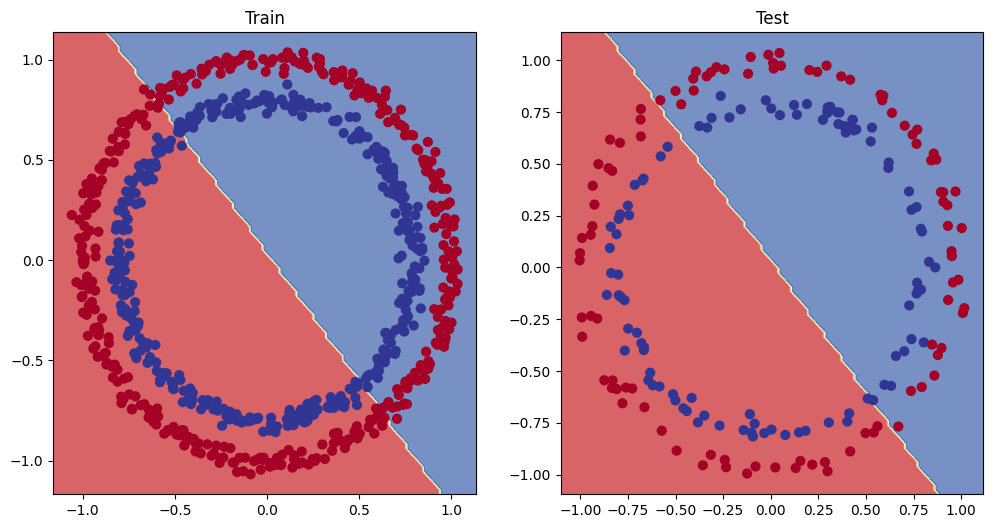

In [29]:
import matplotlib.pyplot as plt
# check decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [ ]:
# 模型效果不好的原因
# 資料分佈是圓形的   但我們的模型試圖使用 linear regression 去分析資料
# 可能需要使用其他分析途徑

# **5. Improve the model**
1. Add more layers - 有更多擷取特徵的機會
2. Add more hidden units - 有更多超參數可以調整 (學習)
3. Add more epochs - 延長學習時間
4. Change activation functions
5. Change learning rate
6. Change loss function

這邊的改進方法, 專注在模型上
實際場景 也有可能是訓練資料出問題

In [46]:
# add layers and hidden units
# 通常在改善模型時 會單個因素 單個因素去調整 才能找到真正出問題的因素

# 模型
class CircleModelV1(nn.Module):
    # 模型架構
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=32)
        self.layer_3 = nn.Linear(in_features=32, out_features=16)
        self.layer_4 = nn.Linear(in_features=16, out_features=1)

    # 向前傳播 的 路徑 (可以指定 要 or 不要 通過某些層)
    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        z = self.layer_4(z)
        return z

model_2 = CircleModelV1().to(device)
model_2

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_4): Linear(in_features=16, out_features=1, bias=True)
)

In [47]:
# 指定 loss function
loss_fn = nn.BCEWithLogitsLoss()

# 指定 optimizer
optimizer = torch.optim.SGD(params = model_2.parameters(),
                lr = 0.1)

In [48]:
# training loop
torch.manual_seed(42)

# 指定訓練次數
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#
for epoch in range(epochs):
    # Training !!!
    model_2.train()

    # 1. Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
               y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing !!!
    model_2.eval()
    with torch.no_grad():
        # 1. Forward pass
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate
        test_loss = loss_fn(test_logits,
                    y_test)
        test_acc = accuracy_fn(y_true = y_test,
                     y_pred = test_pred)

        # Print out process
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}")
            print(f"Loss: {loss:.4f}, Acc:{acc:.2f}%")
            print(f"Test loss: {test_loss:.4f}, Test acc:{test_acc:.2f}%")
            print("=" * 50)

Epoch: 0
Loss: 0.6969, Acc:50.00%
Test loss: 0.6959, Test acc:50.00%
Epoch: 100
Loss: 0.6931, Acc:49.62%
Test loss: 0.6935, Test acc:50.50%
Epoch: 200
Loss: 0.6930, Acc:50.62%
Test loss: 0.6939, Test acc:46.50%
Epoch: 300
Loss: 0.6930, Acc:51.12%
Test loss: 0.6942, Test acc:46.50%
Epoch: 400
Loss: 0.6930, Acc:51.38%
Test loss: 0.6943, Test acc:46.00%
Epoch: 500
Loss: 0.6930, Acc:51.50%
Test loss: 0.6945, Test acc:44.50%
Epoch: 600
Loss: 0.6930, Acc:51.38%
Test loss: 0.6946, Test acc:45.00%
Epoch: 700
Loss: 0.6930, Acc:51.25%
Test loss: 0.6946, Test acc:45.50%
Epoch: 800
Loss: 0.6930, Acc:51.12%
Test loss: 0.6946, Test acc:45.50%
Epoch: 900
Loss: 0.6930, Acc:51.12%
Test loss: 0.6946, Test acc:46.00%


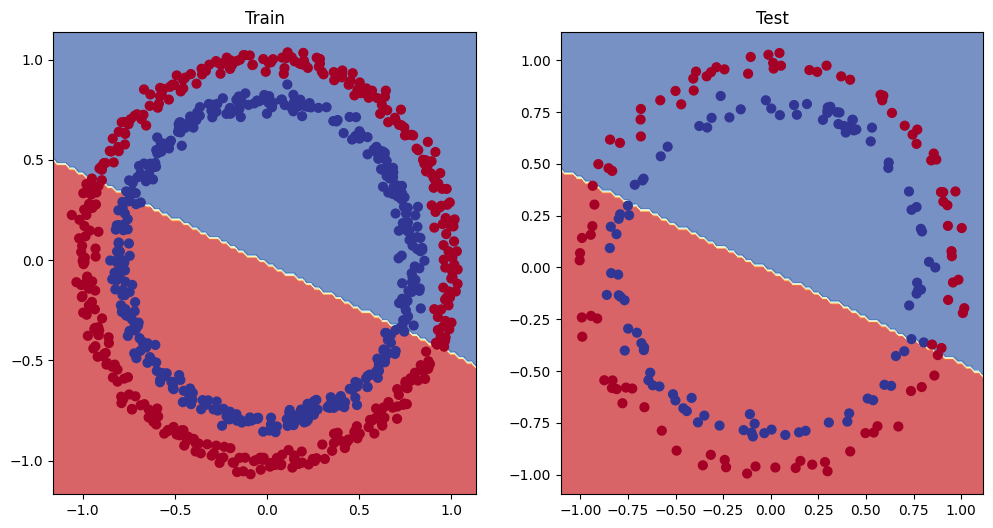

In [ ]:
# 畫圖檢視 again
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

# 5.1. 模型改善練習
starts from model_5

In [52]:
# Subclass nn.Module
class CircleModelV3(nn.Module):
    # 繼承
    def __init__(self):
        super().__init__()
        # 指定 : Layer 架構
        self.layer_1 = nn.Linear(in_features=2, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=128)
        self.layer_3 = nn.Linear(in_features=128, out_features=256)
        self.layer_4 = nn.Linear(in_features=256, out_features=1024)
        self.layer_5 = nn.Linear(in_features=1024, out_features=32)
        self.layer_6 = nn.Linear(in_features=32, out_features=1)

    # subclass nn.Module need implement forward function
    # 指定 : 向前傳播的路徑
    def forward(self, x):
        f = self.layer_1(x)
        f = self.layer_2(f)
        f = self.layer_3(f)
        f = self.layer_4(f)
        f = self.layer_5(f)
        f = self.layer_6(f)
        return f

# 依照指定, 建立模型
model_5 = CircleModelV3().to(device)
model_5

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=1024, bias=True)
  (layer_5): Linear(in_features=1024, out_features=32, bias=True)
  (layer_6): Linear(in_features=32, out_features=1, bias=True)
)

In [53]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss()

In [54]:
# Optimizer (Adam)
optimizer = torch.optim.Adam(params = model_5.parameters(),
                             lr = 0.1)

In [55]:
# Training loop

# Manual_seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Epochs
epochs = 501

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_5.train()

    # 1. Forward pass
    y_logits = model_5(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss (acc is optional)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward pass (負向傳播)
    loss.backward()

    # 5. Optimizer step (調整參數, 梯度下降)
    optimizer.step()

   # Testing !!!
    model_5.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_5(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    # Print out process
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}")
        print(f"Train loss: {loss:.4f}, Train Aacc:{acc:.2f}%")
        print(f"Test loss: {test_loss:.4f}, Test acc:{test_acc:.2f}%")
        print("=" * 50)

Epoch: 0
Train loss: 0.6933, Train Aacc:47.75%
Test loss: 2.0119, Test acc:53.00%
Epoch: 100
Train loss: 2.7902, Train Aacc:51.75%
Test loss: 1.3501, Test acc:52.50%
Epoch: 200
Train loss: 0.6930, Train Aacc:50.12%
Test loss: 0.6960, Test acc:50.50%
Epoch: 300
Train loss: 0.6930, Train Aacc:51.12%
Test loss: 0.6947, Test acc:46.00%
Epoch: 400
Train loss: 0.6930, Train Aacc:51.00%
Test loss: 0.6947, Test acc:46.00%
Epoch: 500
Train loss: 0.6930, Train Aacc:51.00%
Test loss: 0.6947, Test acc:46.00%


# **6 Non-linearity**

# 6.1 Build the model by using non-linearity

In [ ]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Set loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(model_3.parameters(),
                lr = 0.1)

# 6.2 Train model with non-linear

In [ ]:
# Random seeds
torch.manual_seed(42)

#
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#
epochs = 2000

#
for epoch in range(epochs):
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
               y_pred = y_pred)

    # 3. Optimizer
    optimizer.zero_grad()

    # 4. Loass backward (##maybe will update after more batch)
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    # Train !!!
    with torch.no_grad():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                     y_pred = test_pred)

        # Print out process
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}")
            print(f"Loss: {loss:.4f}, Acc:{acc:.2f}%")
            print(f"Test loss: {test_loss:.4f}, Test acc:{test_acc:.2f}%")
            print("=" * 50)

Epoch: 0
Loss: 0.6929, Acc:50.00%
Test loss: 0.6932, Test acc:50.00%
Epoch: 100
Loss: 0.6912, Acc:52.88%
Test loss: 0.6910, Test acc:52.50%
Epoch: 200
Loss: 0.6898, Acc:53.37%
Test loss: 0.6894, Test acc:55.00%
Epoch: 300
Loss: 0.6879, Acc:53.00%
Test loss: 0.6872, Test acc:56.00%
Epoch: 400
Loss: 0.6852, Acc:52.75%
Test loss: 0.6841, Test acc:56.50%
Epoch: 500
Loss: 0.6810, Acc:52.75%
Test loss: 0.6794, Test acc:56.50%
Epoch: 600
Loss: 0.6751, Acc:54.50%
Test loss: 0.6729, Test acc:56.00%
Epoch: 700
Loss: 0.6666, Acc:58.38%
Test loss: 0.6632, Test acc:59.00%
Epoch: 800
Loss: 0.6516, Acc:64.00%
Test loss: 0.6476, Test acc:67.50%
Epoch: 900
Loss: 0.6236, Acc:74.00%
Test loss: 0.6215, Test acc:79.00%
Epoch: 1000
Loss: 0.5682, Acc:87.75%
Test loss: 0.5738, Test acc:86.50%
Epoch: 1100
Loss: 0.4815, Acc:93.50%
Test loss: 0.4993, Test acc:90.50%
Epoch: 1200
Loss: 0.3706, Acc:97.75%
Test loss: 0.4059, Test acc:92.00%
Epoch: 1300
Loss: 0.2546, Acc:99.00%
Test loss: 0.3033, Test acc:96.50%
Epoc

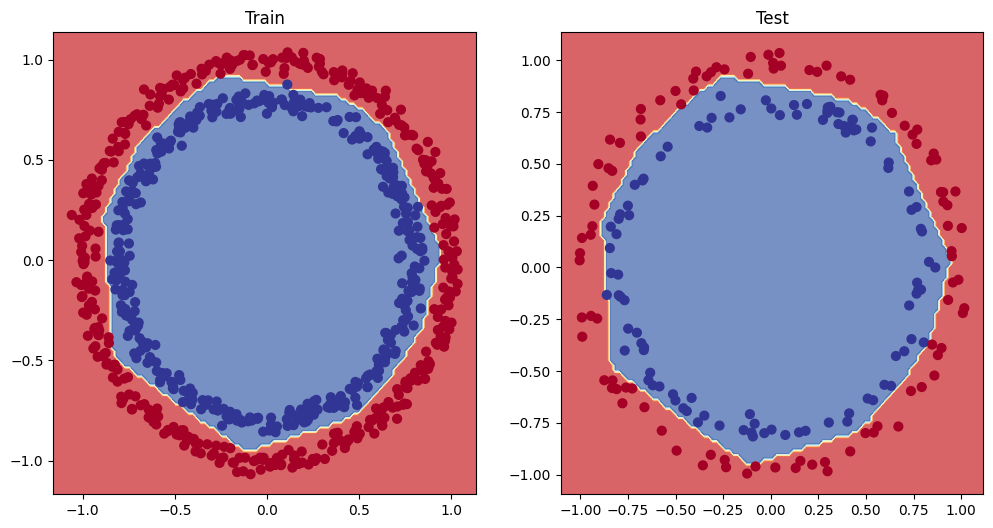

In [ ]:
# 畫圖檢視 again
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# **=== Multi-class classification ===**

# **1. Creating dataset**

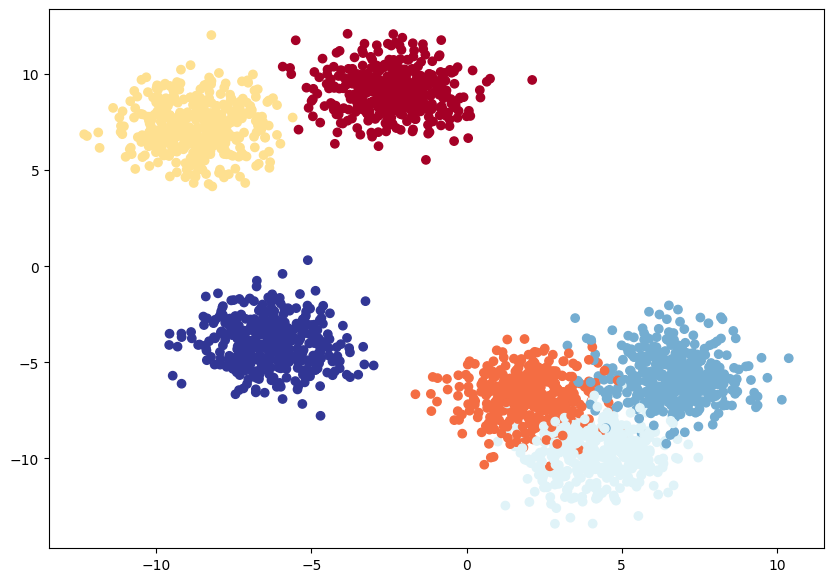

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# 超參數
num_classes = 6
num_features = 3
random_seed = 42

# 1. Creat datasets
X_blob, y_blob = make_blobs(n_samples = 2400,
                 n_features = num_features,
                 centers = num_classes,
                 cluster_std = 1.2, # 賦予資料隨機性
                 random_state = random_seed)

# 2. Trun data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
# Pytorch 在target 這邊使用的資料型態 是 LongTensor
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                              y_blob,
                              test_size = 0.2,
                              random_state = random_seed)

# 4. Plot the data (Visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

# **2. Build multi-class classification model**

In [ ]:
# Device 判斷
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Build
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# model and set to device
model_4 = BlobModel(input_features=3,
            output_features=6,
            hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=6, bias=True)
  )
)

# **3. Create loss function and optimizer**

In [ ]:
# Create loss function
loss_fn = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                lr=0.1)

In [ ]:
# Set accuracy_fn
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

# **4. Getting prediction (check model)**

In order to evaluate & train & test our model
We need to convert model's output to prediction probability and then cpnvert to label


In [ ]:
model_4.eval()

with torch.no_grad():
    y_logits = model_4(X_test.to(device))

y_logits[:2]   # [-0.1535, -0.4210,  0.2340, -0.2328, -0.0810,  0.1347] 與答案的資料型態不一樣

tensor([[-0.1461, -0.4177,  0.2292, -0.2299, -0.0854,  0.1278],
        [-0.0320, -0.1760,  0.3228, -0.0183, -0.0499,  0.0746]])

In [ ]:
y_test[:2]

tensor([3, 4])

In [ ]:
# convert model's output to prediction probability
y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[  1.3383,  -1.1660,  -4.0328,   9.5063,   1.4822,  -6.3484],
        [ -0.6791,  -0.2635,  -0.4956,  -0.6522,   2.8831,  -0.7203],
        [  1.3733,  -3.8097,  -3.4271,   9.7273,  -0.0946,  -5.7858],
        [ -0.6791,  -0.2635,  -0.4956,  -0.6522,   2.8831,  -0.7203],
        [-11.8949,   3.7071,  -1.8227, -14.2567,  -6.8237,  11.1879]])
tensor([[2.8340e-04, 2.3163e-05, 1.3175e-06, 9.9936e-01, 3.2724e-04, 1.3005e-07],
        [2.4423e-02, 3.7009e-02, 2.9344e-02, 2.5090e-02, 8.6070e-01, 2.3439e-02],
        [2.3540e-04, 1.3207e-06, 1.9364e-06, 9.9971e-01, 5.4235e-05, 1.8308e-07],
        [2.4423e-02, 3.7009e-02, 2.9344e-02, 2.5090e-02, 8.6070e-01, 2.3439e-02],
        [9.4408e-11, 5.6345e-04, 2.2350e-06, 8.8976e-12, 1.5044e-08, 9.9943e-01]])


In [ ]:
y_logits.shape

torch.Size([480, 6])

In [ ]:
# convert prediction probability to label

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([2, 2, 2, 2, 5, 3, 2, 2, 5, 3])

In [ ]:
y_test[:10]   # 格式 一樣了

tensor([3, 4, 3, 4, 5, 0, 4, 4, 1, 0])

# **5. Create training loop and testing loop**

In [ ]:
y_logits

tensor([[-0.1461, -0.4177,  0.2292, -0.2299, -0.0854,  0.1278],
        [-0.0320, -0.1760,  0.3228, -0.0183, -0.0499,  0.0746],
        [-0.2256, -0.5198,  0.2202, -0.3138, -0.0830,  0.1814],
        ...,
        [-0.0143, -0.2224,  0.2513, -0.0318, -0.1375,  0.0312],
        [-0.0309, -0.1692,  0.3209,  0.0033, -0.0741,  0.0688],
        [-0.0123, -0.2688,  0.2325, -0.1287, -0.0676,  0.0392]])

In [ ]:
# Fit the model to the data
torch.manual_seed(42)

# Set number of epochs
epochs = 500

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
for epoch in range(epochs):
    # Training !!!
    model_4.train()

    y_logits = model_4(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
               y_pred = y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing !!!
    model_4.eval()
    with torch.no_grad():
        test_logits = model_4(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test,
                      y_pred = test_preds)

    # print process
    if epoch % 50 == 0:
        print("Epoch: ", epoch)
        print(f"Train loss: {loss:.2f} | Train acc: {acc:.2f}%")
        print(f"Test loss: {test_loss:.2f} | Test acc: {test_acc:.2f}%")
        print("=" * 50)

Epoch:  0
Train loss: 1.87 | Train acc: 14.32%
Test loss: 1.77 | Test acc: 16.46%
Epoch:  50
Train loss: 0.43 | Train acc: 95.68%
Test loss: 0.40 | Test acc: 96.04%
Epoch:  100
Train loss: 0.20 | Train acc: 98.18%
Test loss: 0.19 | Test acc: 97.29%
Epoch:  150
Train loss: 0.14 | Train acc: 98.85%
Test loss: 0.13 | Test acc: 98.54%
Epoch:  200
Train loss: 0.10 | Train acc: 99.22%
Test loss: 0.10 | Test acc: 98.75%
Epoch:  250
Train loss: 0.08 | Train acc: 99.22%
Test loss: 0.09 | Test acc: 98.96%
Epoch:  300
Train loss: 0.07 | Train acc: 99.17%
Test loss: 0.07 | Test acc: 98.96%
Epoch:  350
Train loss: 0.06 | Train acc: 99.22%
Test loss: 0.07 | Test acc: 98.96%
Epoch:  400
Train loss: 0.05 | Train acc: 99.22%
Test loss: 0.06 | Test acc: 98.96%
Epoch:  450
Train loss: 0.05 | Train acc: 99.22%
Test loss: 0.06 | Test acc: 98.75%


# **6. Make prediction**

In [ ]:
model_4.eval()
with torch.no_grad():
    y_logits = model_4(X_test)

y_logits[:10]

tensor([[  1.3383,  -1.1660,  -4.0328,   9.5063,   1.4822,  -6.3484],
        [ -0.6791,  -0.2635,  -0.4956,  -0.6522,   2.8831,  -0.7203],
        [  1.3733,  -3.8097,  -3.4271,   9.7273,  -0.0946,  -5.7858],
        [ -0.6791,  -0.2635,  -0.4956,  -0.6522,   2.8831,  -0.7203],
        [-11.8949,   3.7071,  -1.8227, -14.2567,  -6.8237,  11.1879],
        [  9.2352, -14.5269,  -1.5756,  -1.7132,  -7.8152,  -6.3700],
        [ -0.6791,  -0.2635,  -0.4956,  -0.6522,   2.8831,  -0.7203],
        [ -1.0717,   0.5871,  -0.8411,  -1.0204,   2.7487,  -0.5723],
        [ -6.3566,   9.3527,  -4.2112,  -6.3181,   0.1787,   2.2960],
        [  8.3450, -14.7084,  -0.3029,  -2.7308,  -7.7213,  -5.4640]])

In [ ]:
y_preds_probs = torch.softmax(y_logits, dim=1)
y_preds_probs[:10]

tensor([[2.8340e-04, 2.3163e-05, 1.3175e-06, 9.9936e-01, 3.2724e-04, 1.3005e-07],
        [2.4423e-02, 3.7009e-02, 2.9344e-02, 2.5090e-02, 8.6070e-01, 2.3439e-02],
        [2.3540e-04, 1.3207e-06, 1.9364e-06, 9.9971e-01, 5.4235e-05, 1.8308e-07],
        [2.4423e-02, 3.7009e-02, 2.9344e-02, 2.5090e-02, 8.6070e-01, 2.3439e-02],
        [9.4408e-11, 5.6345e-04, 2.2350e-06, 8.8976e-12, 1.5044e-08, 9.9943e-01],
        [9.9996e-01, 4.7889e-11, 2.0181e-05, 1.7585e-05, 3.9363e-08, 1.6701e-07],
        [2.4423e-02, 3.7009e-02, 2.9344e-02, 2.5090e-02, 8.6070e-01, 2.3439e-02],
        [1.7909e-02, 9.4082e-02, 2.2556e-02, 1.8853e-02, 8.1709e-01, 2.9510e-02],
        [1.5035e-07, 9.9903e-01, 1.2849e-06, 1.5626e-07, 1.0360e-04, 8.6079e-04],
        [9.9981e-01, 9.7266e-11, 1.7547e-04, 1.5480e-05, 1.0530e-07, 1.0064e-06]])

In [ ]:
y_preds = torch.argmax(y_preds_probs, dim=1)

In [ ]:
y_test

print( len(y_preds == y_test) / len(y_preds) )
# 準確率 100%
# 教程僅使用兩種特徵 我們設定三維   所以沒有辦法畫圖

1.0


# **=== 額外補充 (Other way to evaluate model) ===**
1. 目前僅使用 Accuracy
2. Precision
3. Recall
4. F1-score
5. Confusion matrix
6. Classification report

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.1 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_test)

tensor(0.9875)